In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
import xarray as xr
import numpy as np
from tensorflow import keras
from src.score import *

DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['orography']
}

ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, bins_z = None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        output_data = self.data.isel(level = self.output_idxs)

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.bins_z = np.linspace(output_data.min(), output_data.max(), 100) if bins_z is None else bins_z

        self.binned_data = xr.DataArray(
               np.digitize(output_data[:, :, :, 0], self.bins_z)-1,
               dims=['time', 'lat', 'lon'],
               coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values
               })

        del ds
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time   
        
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load() 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)    

In [2]:
import re

bs=32
lead_time=72
output_vars = ['z_500']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, bins_z = dg_train.bins_z, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z,
                         shuffle=False, output_vars=output_vars)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [3]:
fc_arg = np.load('pred.npy')

In [6]:
fc_conv_ds = xr.Dataset({
    'z': xr.DataArray(
        fc_arg,
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})

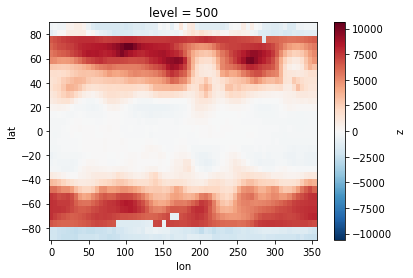

In [10]:
(fc_conv_ds.z.isel(time = 0) - ds_test.z.sel(level = 500).isel(time = 0)).plot()